In [ ]:
import os
import random
import cv2

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

---

# Задача детекции пневмонии (бинарная классификация) - экзаменационное задание.
# Выполнил: Кузнецов К.И.

---
## Технический раздел (подготовка тренировочных, валидационных и тестовых датасетов)

In [ ]:
# Создаём список текстовых меток на основе числовых значений
labels = ["Normal", "Pneumonia"]  # индекс 0 → Normal, индекс 1 → Pneumonia

# Размер, к которому будут приводиться все изображения
img_size = 224

def get_training_data(data_dir, limit_per_class=None, extensions=('.png', '.jpg', '.jpeg')):
    """
    Загружает изображения из подпапок указанной директории,
    преобразует их в массивы NumPy и помечает соответствующим классом.

    Parameters:
    - data_dir (str): путь к папке с данными (в ней должны быть подпапки по классам)
    - limit_per_class (int or None): максимальное число изображений на класс
                                      (полезно для тестирования)
    - extensions (tuple): допустимые расширения файлов

    Returns:
    - np.array: массив с данными в формате [image_array, label]
    """
    
    data = []
    
    # Проходим по каждому классу
    for label in labels:
        class_path = os.path.join(data_dir, label)  # Путь к папке с классом
        
        # Проверяем, существует ли такая папка
        if not os.path.isdir(class_path):
            print(f"Папка не найдена: {class_path}")
            continue

        class_num = labels.index(label)  # Получаем индекс класса (метку)
        count = 0  # Счётчик изображений на класс

        print(f"[INFO] Загрузка изображений из папки '{label}'...")

        # Перебираем все файлы в папке класса
        for img_file in os.listdir(class_path):
            if limit_per_class is not None and count >= limit_per_class:
                break  # Ограничиваем количество загружаемых изображений

            file_path = os.path.join(class_path, img_file)

            # Пропускаем, если это не изображение
            if not img_file.lower().endswith(extensions):
                print(f"[SKIP] Неизвестный формат файла: {file_path}")
                continue

            try:
                # Чтение изображения в оттенках серого
                img_arr = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                if img_arr is None:
                    print(f"[ERROR] Не удалось прочитать файл: {file_path}")
                    continue

                # Изменение размера
                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                # Добавление в общий список
                data.append([resized_arr, class_num])
                count += 1

            except Exception as e:
                print(f"[ERROR] Ошибка при обработке файла {file_path}: {e}")

        print(f"[INFO] Загружено {count} изображений из категории '{label}'.")

    print(f"[INFO] Общее количество загруженных изображений: {len(data)}")
    return np.array(data, dtype=object)  # Используем dtype=object, чтобы сохранить разные типы

In [7]:
train = get_training_data("./chest_xray/train")
test = get_training_data("./chest_xray/test")
val = get_training_data("./chest_xray/val")

[INFO] Загрузка изображений из папки 'Normal'...
[INFO] Загружено 1341 изображений из категории 'Normal'.
[INFO] Загрузка изображений из папки 'Pneumonia'...
[INFO] Загружено 3875 изображений из категории 'Pneumonia'.
[INFO] Общее количество загруженных изображений: 5216
[INFO] Загрузка изображений из папки 'Normal'...
[INFO] Загружено 234 изображений из категории 'Normal'.
[INFO] Загрузка изображений из папки 'Pneumonia'...
[INFO] Загружено 390 изображений из категории 'Pneumonia'.
[INFO] Общее количество загруженных изображений: 624
[INFO] Загрузка изображений из папки 'Normal'...
[INFO] Загружено 8 изображений из категории 'Normal'.
[INFO] Загрузка изображений из папки 'Pneumonia'...
[INFO] Загружено 8 изображений из категории 'Pneumonia'.
[INFO] Общее количество загруженных изображений: 16


---
## Ознакомление с данными

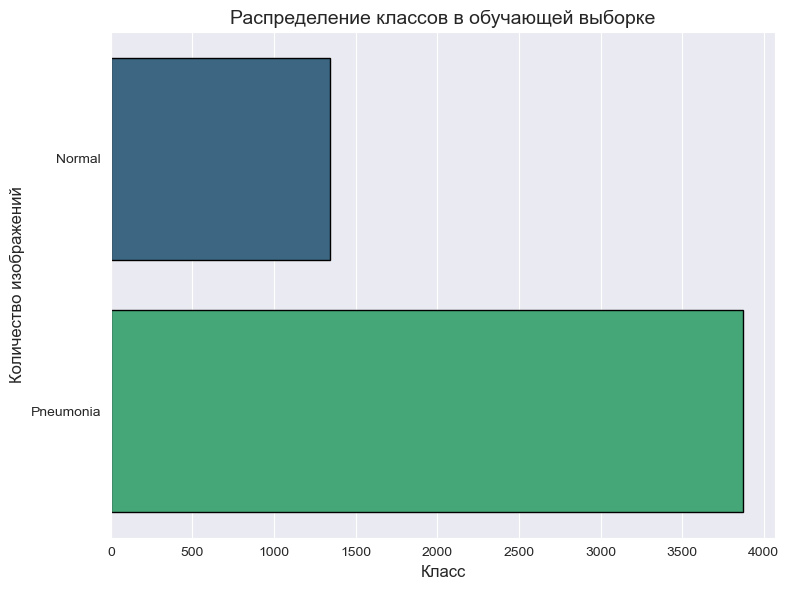

In [ ]:
# Генерируем список человекочитаемых названий классов
class_labels = [labels[item[1]] for item in train]

# Устанавливаем стиль графиков (тема)
sns.set_style("darkgrid")

# Строим столбчатый график количества изображений каждого класса
plt.figure(figsize=(8, 6))  # задаём размер графика
ax = sns.countplot(
    data=class_labels,      # данные для отрисовки
    palette="viridis",      # цветовая палитра
    edgecolor="black",       # границы столбцов
)

# Добавляем подписи к столбцам
total = len(class_labels)  # общее количество образцов
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2  # центр столбца по горизонтали
    y = p.get_height()                 # высота столбца


# Добавляем заголовок и метки осей
plt.title("Распределение классов в обучающей выборке", fontsize=14)
plt.xlabel("Класс", fontsize=12)
plt.ylabel("Количество изображений", fontsize=12)

# Показываем график
plt.tight_layout()
plt.show()

> Наблюдается явный дисбаланс классов

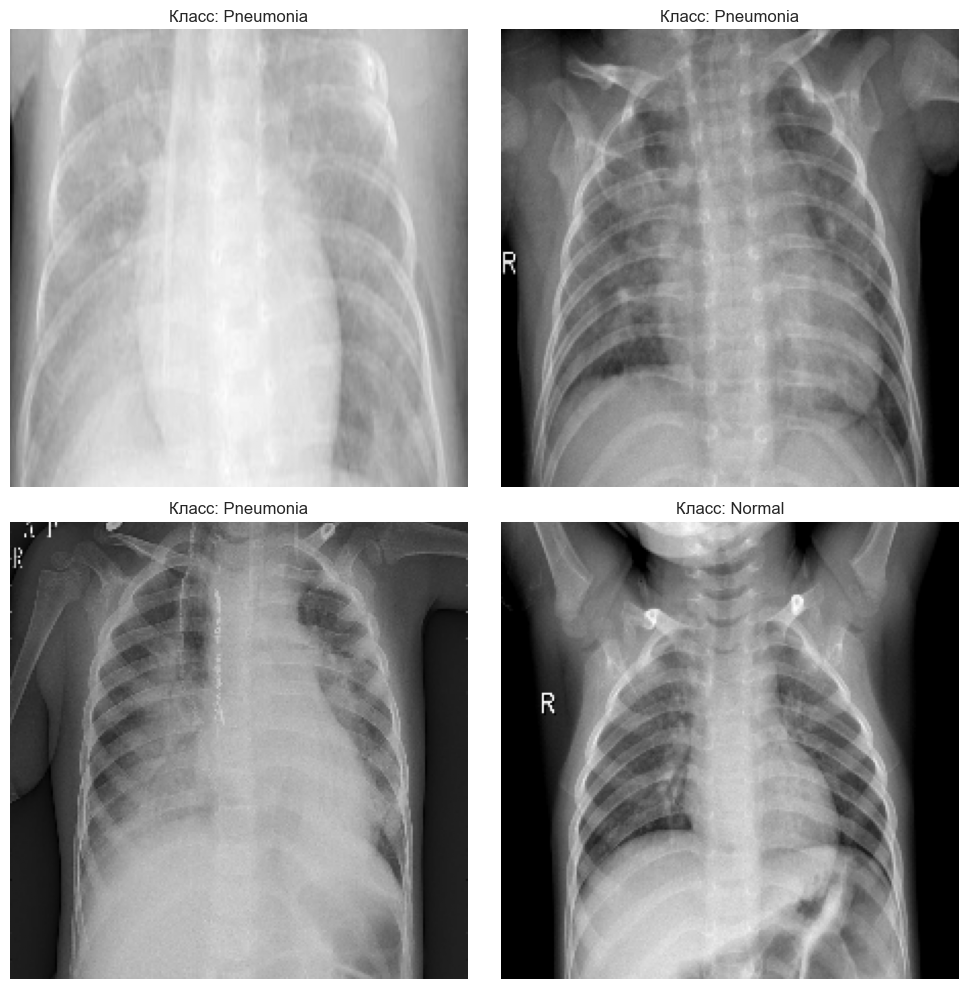

In [9]:
# Выводим 4 случайных изображения
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    idx = random.randint(0, len(train)-1)
    image, label = train[idx]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Класс: {labels[label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

---
## Предподготовка (ресайз+номализация+аугментации)

In [18]:
# Размер изображений для модели
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 12
learning_rate = 1e-3

# Списки для хранения признаков (изображений) и меток
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

# Разделение данных на признаки и метки
print("[INFO] Извлечение признаков и меток из набора train, val, test...")
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

# Преобразование списков в массивы NumPy
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Проверка формы данных
print(f"[INFO] Форма x_train: {x_train.shape}")
print(f"[INFO] Форма x_val: {x_val.shape}")
print(f"[INFO] Форма x_test: {x_test.shape}")

# Ресайзинг изображений до 224x224
print("[INFO] Увеличение размера изображений до", IMG_SIZE, "x", IMG_SIZE)
x_train_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in x_train])
x_val_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in x_val])
x_test_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in x_test])

# Добавление канала (для совместимости с CNN)
x_train_resized = x_train_resized.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_val_resized = x_val_resized.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_test_resized = x_test_resized.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Нормализация пикселей к диапазону [-1, 1]
print("[INFO] Нормализация данных к диапазону [-1, 1]")
x_train_norm = (x_train_resized.astype('float32') / 255) * 2 - 1
x_val_norm = (x_val_resized.astype('float32') / 255) * 2 - 1
x_test_norm = (x_test_resized.astype('float32') / 255) * 2 - 1

# Аугментация данных с помощью ImageDataGenerator
print("[INFO] Настройка аугментации...")
augmentated_data = ImageDataGenerator(
    rotation_range=30,           # повороты до 30 градусов
    width_shift_range=0.1,       # горизонтальные сдвиги
    height_shift_range=0.1,      # вертикальные сдвиги
    zoom_range=0.2,              # зум
    horizontal_flip=True,         # горизонтальное отражение
    vertical_flip=False          # без вертикальных отражений
)

# Обучаем нормализацию на тренировочных данных (необязательно, но может помочь)
augmentated_data.fit(x_train_norm)

# Результирующие данные готовы к использованию:
print("[INFO] Подготовка данных завершена.")
print("Пример данных после препроцессинга:", x_train_norm.shape, y_train.shape)

[INFO] Извлечение признаков и меток из набора train, val, test...
[INFO] Форма x_train: (5216, 224, 224)
[INFO] Форма x_val: (16, 224, 224)
[INFO] Форма x_test: (624, 224, 224)
[INFO] Увеличение размера изображений до 224 x 224
[INFO] Нормализация данных к диапазону [-1, 1]
[INFO] Настройка аугментации...
[INFO] Подготовка данных завершена.
Пример данных после препроцессинга: (5216, 224, 224, 1) (5216,)


---
## Базовая модель CNN

In [19]:
def baseline_model(learning_rate=1e-3):
    """
    Создаёт базовую CNN-модель для задачи бинарной классификации изображений.
    
    Архитектура:
        - Свёрточные блоки: Conv2D -> Conv2D -> MaxPool2D -> Dropout
        - Полносвязные слои: Dense -> BatchNorm -> Dropout
        - Выходной слой: сигмоида для бинарной классификации
    
    Параметры:
        learning_rate (float): скорость обучения для оптимизатора Adam
    
    Возвращает:
        model (tf.keras.Model): скомпилированная модель
    """
    
    print("[INFO] Создание модели...")

    model = Sequential([
        # Входной слой: размер входных изображений
        Input(shape=(IMG_SIZE, IMG_SIZE, 1)),

        # Блок 1
        layers.Conv2D(16, 3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.Conv2D(16, 3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.MaxPooling2D(3, strides=2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Блок 2
        layers.Conv2D(32, 3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.Conv2D(32, 3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.MaxPooling2D(3, strides=2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Блок 3
        layers.Conv2D(64, 3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.Conv2D(64, 3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.GlobalAveragePooling2D(),

        # Полносвязные слои
        layers.Dense(128, use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(64, use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Выходной слой (для бинарной классификации)
        layers.Dense(1, activation='sigmoid')
    ])

    # Компиляция модели
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='AUC')
        ]
    )

    print("[INFO] Модель успешно создана.")
    model.summary()

    return model

In [ ]:
# Обучение модели
model = baseline_model(learning_rate=learning_rate)

# Callback: снижение скорости обучения при стагнации
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

# Генераторы с аугментацией
train_generator = augmentated_data.flow(x_train_norm, y_train, batch_size=BATCH_SIZE)
val_generator = augmentated_data.flow(x_val_norm, y_val, batch_size=BATCH_SIZE)

# Обучение
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[reduce_lr],
    verbose=1
)

print("[INFO] Обучение завершено.")

# Сохраним baseline результат
model.save("pneumonia_cnn_model_base.h5")
print("[INFO] Модель сохранена как pneumonia_cnn_model.h5")

[INFO] Создание модели...


2025-06-15 12:06:42.177166: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-06-15 12:06:42.181281: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-15 12:06:42.181881: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-15 12:06:42.181933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-15 12:06:42.182278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[INFO] Модель успешно создана.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 16)   │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 111, 111, 32)   │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 111, 111, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 55, 55, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 55, 55, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 55, 55, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             

 Total params: 88,977 (347.57 KB)

 Trainable params: 88,497 (345.69 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/12


2025-06-15 12:06:45.002564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 265ms/step - AUC: 0.8312 - accuracy: 0.7430 - loss: 0.5734 - precision: 0.9233 - recall: 0.7138 - val_AUC: 0.6328 - val_accuracy: 0.5000 - val_loss: 0.8198 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 264ms/step - AUC: 0.9301 - accuracy: 0.8829 - loss: 0.3149 - precision: 0.9353 - recall: 0.9058 - val_AUC: 0.6484 - val_accuracy: 0.5000 - val_loss: 1.6865 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - AUC: 0.9405 - accuracy: 0.8910 - loss: 0.2759 - precision: 0.9249 - recall: 0.9257
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 279ms/step - AUC: 0.9405 - accuracy: 0.8911 - loss: 0.2759 - precision: 0.9250 - recall: 0.9257 - val_AUC: 0.4609 - val_accuracy: 0.5000 - val_loss: 2.4018 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010


[INFO] Обучение завершено.
[INFO] Модель сохранена как pneumonia_cnn_model.h5


[INFO] Оценка модели на тестовой выборке...
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

[RESULT] Ключевые метрики модели:
Accuracy  : 0.8077
Precision : 0.7766
Recall    : 0.9718
F1 Score  : 0.8633
ROC AUC   : 0.9036


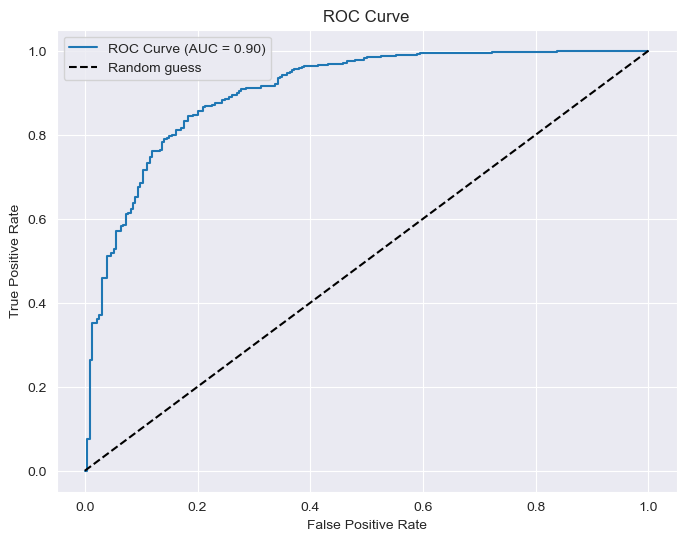

In [ ]:
# Предсказания на тестовой выборке
print("[INFO] Оценка модели на тестовой выборке...")

# Получаем вероятности классов
y_pred_proba = model.predict(x_test_norm).flatten()

# Преобразуем в бинарные предсказания (0 или 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Истинные метки
y_true = y_test


# Расчёт метрик

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba)

# 3. Вывод метрик в табличном виде
print("\n[RESULT] Ключевые метрики модели:")
print(f"{'Accuracy':<10}: {accuracy:.4f}")
print(f"{'Precision':<10}: {precision:.4f}")
print(f"{'Recall':<10}: {recall:.4f}")
print(f"{'F1 Score':<10}: {f1:.4f}")
print(f"{'ROC AUC':<10}: {roc_auc:.4f}")

# 4. Визуализация: ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Полученная модель:

- Очень чувствительна к наличию пневмонии (высокий Recall).
- Иногда ложно диагностирует пневмонию , когда её нет (низкий Precision).
- Итоговый F1-score = 0.86 говорит о достаточно хорошей общей эффективности.

Возможные улучшения перед углублением модели:

- Можно увеличить порог классификации (> 0.5)
- Использовать веса классов (class_weight)

In [31]:
# усиливаем важность класса "пневмония"
class_weight = {0: 1., 1: 2.}

# Обучение
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[reduce_lr],
    verbose=1,
    class_weight=class_weight
)

print("[INFO] Обучение завершено.")

# Сохраним baseline результат
model.save("pneumonia_cnn_model_base_optimised.h5")
print("[INFO] Модель сохранена как pneumonia_cnn_model.h5")

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - AUC: 0.9783 - accuracy: 0.9387 - loss: 0.2375 - precision: 0.9528 - recall: 0.9646 - val_AUC: 1.0000 - val_accuracy: 0.5625 - val_loss: 1.3935 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 8.1000e-06
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - AUC: 0.9796 - accuracy: 0.9353 - loss: 0.2279 - precision: 0.9486 - recall: 0.9648 - val_AUC: 1.0000 - val_accuracy: 0.5625 - val_loss: 1.1448 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 8.1000e-06
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 285ms/step - AUC: 0.9802 - accuracy: 0.9389 - loss: 0.2277 - precision: 0.9491 - recall: 0.9690 - val_AUC: 0.9766 - val_accuracy: 0.7500 - val_loss: 0.8784 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 8.1000e-06
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 279ms/step - AUC: 0.9835 - accuracy: 0.9437 - loss: 0.2084 - precision: 0.9523 - recall: 0.9731 - val_AUC: 0.9844 - val_accuracy: 0.6250 

[INFO] Модель сохранена как pneumonia_cnn_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step

[RESULT] Ключевые метрики модели:
Accuracy  : 0.7949
Precision : 0.7631
Recall    : 0.9744
F1 Score  : 0.8559
ROC AUC   : 0.8952


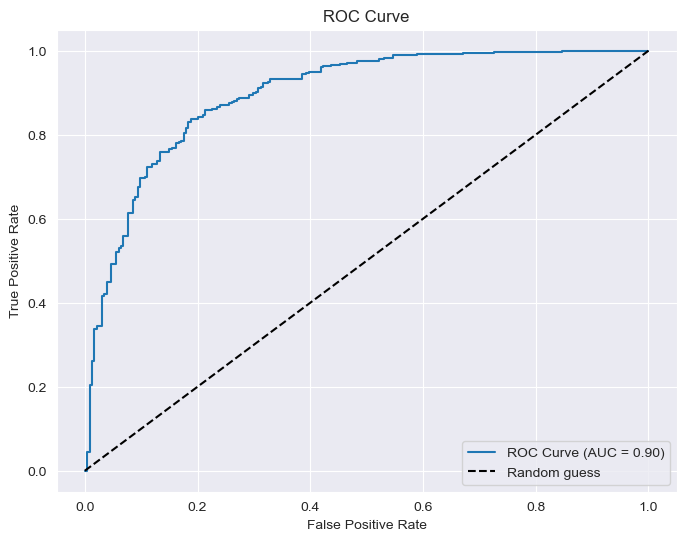

In [ ]:
# Получаем вероятности
y_pred_proba = model.predict(x_test_norm).flatten()

# Устанавливаем новый порог
threshold = 0.6
y_pred_new = (y_pred_proba >= threshold).astype(int)

# Расчёт метрик
accuracy = accuracy_score(y_true, y_pred_new)
precision = precision_score(y_true, y_pred_new)
recall = recall_score(y_true, y_pred_new)
f1 = f1_score(y_true, y_pred_new)
roc_auc = roc_auc_score(y_true, y_pred_proba)

# 3. Вывод метрик в табличном виде
print("\n[RESULT] Ключевые метрики модели:")
print(f"{'Accuracy':<10}: {accuracy:.4f}")
print(f"{'Precision':<10}: {precision:.4f}")
print(f"{'Recall':<10}: {recall:.4f}")
print(f"{'F1 Score':<10}: {f1:.4f}")
print(f"{'ROC AUC':<10}: {roc_auc:.4f}")

# 4. Визуализация: ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

> Предположения об изменении порога и весовом распределении оказались не подтвержденными, переходим к глубокой модели.

---
## Продвинутая CNN

In [28]:
def deep_model(learning_rate=1e-3):
    """
    Создаёт глубокую CNN-модель с SE-блоками и улучшенной архитектурой.
    
    Возвращает:
        model (tf.keras.Model): скомпилированная модель
    """
    print("[INFO] Создание глубокой модели...")

    def se_block(input_tensor, ratio=16):
        """Squeeze-and-Excitation блок"""
        channel_axis = -1
        filters = input_tensor.shape[channel_axis]
        se_shape = (1, 1, filters)

        se = layers.GlobalAveragePooling2D()(input_tensor)
        se = layers.Reshape(se_shape)(se)
        se = layers.Conv2D(filters // ratio, 1, activation='relu', padding='same')(se)
        se = layers.Conv2D(filters, 1, activation='sigmoid', padding='same')(se)

        return layers.multiply([input_tensor, se])

    def conv_block(x, filters, kernel_size=3):
        """Блок из двух Conv2D + BatchNorm + GELU + SE + MaxPool"""
        x = layers.Conv2D(filters, kernel_size, padding='same', use_bias=False)(x)
        x = layers.Activation(tf.nn.gelu)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, kernel_size, padding='same', use_bias=False)(x)
        x = layers.Activation(tf.nn.gelu)(x)
        x = layers.BatchNormalization()(x)

        x = se_block(x)
        x = layers.MaxPooling2D(3, strides=2)(x)
        x = layers.Dropout(0.2)(x)
        return x

    # === Functional API ===
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    x = layers.Conv2D(16, 3, padding='same', use_bias=False)(inputs)
    x = layers.Activation(tf.nn.gelu)(x)
    x = layers.BatchNormalization()(x)

    x = conv_block(x, filters=16)
    x = conv_block(x, filters=32)
    x = conv_block(x, filters=64)
    x = conv_block(x, filters=128)
    x = conv_block(x, filters=256)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, use_bias=False)(x)
    x = layers.Activation(tf.nn.gelu)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, use_bias=False)(x)
    x = layers.Activation(tf.nn.gelu)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, use_bias=False)(x)
    x = layers.Activation(tf.nn.gelu)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='AUC')
        ]
    )

    print("[INFO] Глубокая модель успешно создана.")
    model.summary()

    return model

In [ ]:
# Обучение модели
model_deep = deep_model(learning_rate=learning_rate)

# Callback: снижение скорости обучения при стагнации
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

# Генераторы с аугментацией
train_generator = augmentated_data.flow(x_train_norm, y_train, batch_size=BATCH_SIZE)
val_generator = augmentated_data.flow(x_val_norm, y_val, batch_size=BATCH_SIZE)

# Обучение
history = model_deep.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[reduce_lr],
    verbose=1
)

print("[INFO] Обучение завершено.")

# Сохраним результат
model_deep.save("pneumonia_cnn_model_deep.h5")
print("[INFO] Модель сохранена как pneumonia_cnn_model.h5")

[INFO] Создание глубокой модели...
[INFO] Глубокая модель успешно создана.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 224, 224,  │        144 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 224, 224,  │          0 │ conv2d_8[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ activation_10[0]… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │      2,304 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 224, 224,  │          0 │ conv2d_9[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ activation_11[0]… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 224, 224,  │      2,304 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 224, 224,  │          0 │ conv2d_10[0][0]   │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ activation_12[0]… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 16)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 1, 1, 1)   │         17 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 1, 1, 16)  │         32 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 111, 111,  │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 111, 111,  │          0 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 111, 111,  │      4,608 │ dropout_4[0][0] 

 Total params: 1,477,184 (5.64 MB)

 Trainable params: 1,473,504 (5.62 MB)

 Non-trainable params: 3,680 (14.38 KB)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 835ms/step - AUC: 0.8589 - accuracy: 0.7749 - loss: 0.5345 - precision: 0.9275 - recall: 0.7587 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 1.9202 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 812ms/step - AUC: 0.9517 - accuracy: 0.8999 - loss: 0.2722 - precision: 0.9432 - recall: 0.9187 - val_AUC: 0.6250 - val_accuracy: 0.5000 - val_loss: 2.6549 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - AUC: 0.9656 - accuracy: 0.9256 - loss: 0.2056 - precision: 0.9428 - recall: 0.9569
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 838ms/step - AUC: 0.9656 - accuracy: 0.9255 - loss: 0.2056 - precision: 0.9428 - recall: 0.9569 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 2.8536 - val_precision: 0.5000 - val_recall: 1.0000 - learning

[INFO] Обучение завершено.
[INFO] Модель сохранена как pneumonia_cnn_model.h5


[INFO] Оценка модели на тестовой выборке...
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step

[RESULT] Ключевые метрики модели:
Accuracy  : 0.8974
Precision : 0.9116
Recall    : 0.9256
F1 Score  : 0.9186
ROC AUC   : 0.9499


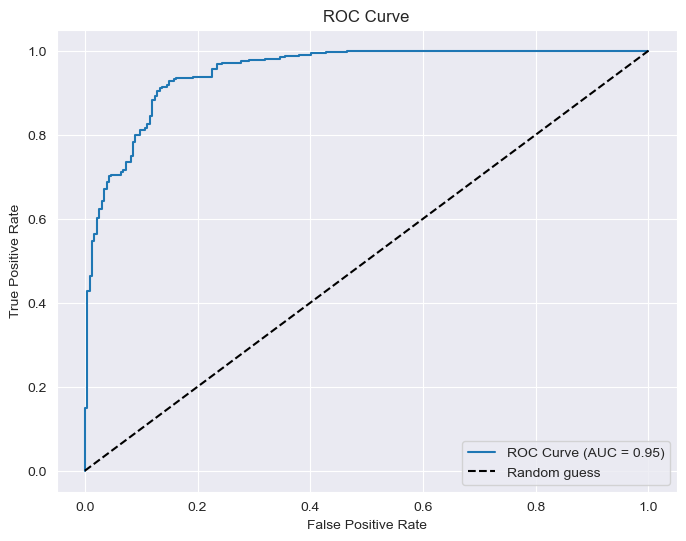

In [ ]:
# Предсказания на тестовой выборке

print("[INFO] Оценка модели на тестовой выборке...")

# Получаем вероятности классов
y_pred_proba = model_deep.predict(x_test_norm).flatten()

# Преобразуем в бинарные предсказания (0 или 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Истинные метки
y_true = y_test


# Расчёт метрик
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba)

# 3. Вывод метрик в табличном виде
print("\n[RESULT] Ключевые метрики модели:")
print(f"{'Accuracy':<10}: {accuracy:.4f}")
print(f"{'Precision':<10}: {precision:.4f}")
print(f"{'Recall':<10}: {recall:.4f}")
print(f"{'F1 Score':<10}: {f1:.4f}")
print(f"{'ROC AUC':<10}: {roc_auc:.4f}")

# 4. Визуализация: ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Все ключевые метрики значительно улучшились:

- Accuracy = 0.8974

- Precision = 0.9116

- F1 Score = 0.9186

- ROC AUC = 0.9499
 
 Это говорит о том, что модель обучилась намного лучше и более точно делает выводы . 

Что чуть хуже:

Recall стал немного ниже (0.9256) , чем у baseline, но это компромисс за рост Precision.
То есть, теперь модель чуть чаще пропускает некоторые сложные случаи, но в разы реже ошибается в сторону "пневмонии" . 

Можно однозначно сказать, что итоговая модель предпочтительнее в рамках использования детекции пневмонии.